# Introduction

Commercial banks receive a lot of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build an automatic credit card approval predictor using machine learning techniques, just like the real banks do.

![Credit card being held in hand](https://assets.datacamp.com/production/project_558/img/credit_card.jpg)
    
We'll use the [Credit Card Approval dataset](http://archive.ics.uci.edu/ml/datasets/credit+approval) from the UCI Machine Learning Repository. The structure of this notebook is as follows:

- First, we will start off by loading and viewing the dataset.
- We will see that the dataset has a mixture of both numerical and non-numerical features, that it contains values from different ranges, plus that it contains a number of missing entries.
- We will have to preprocess the dataset to ensure the machine learning model we choose can make good predictions.
- After our data is in good shape, we will do some exploratory data analysis to build our intuitions.
- Finally, we will build a machine learning model that can predict if an individual's application for a credit card will be accepted.

First, loading and viewing the dataset. We find that since this data is confidential, the contributor of the dataset has anonymized the feature names.

# Imports

In [1]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

In [2]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [3]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib.ticker import PercentFormatter

px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (average_precision_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, plot_precision_recall_curve,
                             precision_recall_curve, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     cross_validate, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, StandardScaler,
                                   scale)

# Functions

In [5]:
def plot_confusion_matrix(data):
    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = [f"{value:0.0f}" for value in data.flatten()]
    group_percentages = [
        f"{value:.2%}" for value in data.flatten() / np.sum(data)
    ]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(data, annot=labels, fmt="", cmap="Blues")

# Data

In [6]:
# Load dataset
cc_apps = pd.read_csv("datasets/cc_approvals.data", header=None)

# Inspect data
cc_apps.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
77,a,19.17,0.585,y,p,aa,v,0.585,t,f,0,t,g,00160,0,-
585,b,73.42,17.750,u,g,ff,ff,0.000,t,f,0,t,g,00000,0,+
420,b,35.00,2.500,u,g,i,v,1.000,f,f,0,t,g,00210,0,-
418,b,38.42,0.705,u,g,c,v,0.375,f,t,2,f,g,00225,500,-
31,b,42.00,9.790,u,g,x,h,7.960,t,t,8,f,g,00000,0,+
583,b,32.67,9.000,y,p,w,h,5.250,t,f,0,t,g,00154,0,+
568,b,43.08,0.375,y,p,c,v,0.375,t,t,8,t,g,00300,162,+
434,b,58.58,2.710,u,g,c,v,2.415,f,f,0,t,g,00320,0,-
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,00100,3,+
68,b,19.42,6.500,u,g,w,h,1.460,t,t,7,f,g,00080,2954,+


In [7]:
# inspect
profile_report = cc_apps.profile_report(
    sort=None, explorative=True, html={"style": {"full_width": True}}, progress_bar=True
)
profile_report.to_file("docs/example_profiling.html")

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA

## Inspecting the applications

The output may appear a bit confusing at its first sight, but let's try to figure out the most important features of a credit card application. The features of this dataset have been anonymized to protect the privacy, but <a href="http://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html">this blog</a> gives us a pretty good overview of the probable features. The probable features in a typical credit card application are <code>Gender</code>, <code>Age</code>, <code>Debt</code>, <code>Married</code>, <code>BankCustomer</code>, <code>EducationLevel</code>, <code>Ethnicity</code>, <code>YearsEmployed</code>, <code>PriorDefault</code>, <code>Employed</code>, <code>CreditScore</code>, <code>DriversLicense</code>, <code>Citizen</code>, <code>ZipCode</code>, <code>Income</code> and finally the <code>ApprovalStatus</code>. This gives us a pretty good starting point, and we can map these features with respect to the columns in the output.   </p>

As we can see from our first glance at the data, the dataset has a mixture of numerical and non-numerical features. This can be fixed with some preprocessing, but before we do that, let's learn about the dataset a bit more to see if there are other dataset issues that need to be fixed.

In [8]:
# Print summary statistics
cc_apps_description = cc_apps.describe()
print(cc_apps_description)

print("\n")

# Print DataFrame information
cc_apps_info = cc_apps.info()
print(cc_apps_info)

print("\n")

# Inspect missing values in the dataset
cc_apps.tail(17)

                2           7         10             14
count  690.000000  690.000000  690.00000     690.000000
mean     4.758725    2.223406    2.40000    1017.385507
std      4.978163    3.346513    4.86294    5210.102598
min      0.000000    0.000000    0.00000       0.000000
25%      1.000000    0.165000    0.00000       0.000000
50%      2.750000    1.000000    0.00000       5.000000
75%      7.207500    2.625000    3.00000     395.500000
max     28.000000   28.500000   67.00000  100000.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 no

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
673,?,29.50,2.000,y,p,e,h,2.000,f,f,0,f,g,00256,17,-
674,a,37.33,2.500,u,g,i,h,0.210,f,f,0,f,g,00260,246,-
675,a,41.58,1.040,u,g,aa,v,0.665,f,f,0,f,g,00240,237,-
676,a,30.58,10.665,u,g,q,h,0.085,f,t,12,t,g,00129,3,-
677,b,19.42,7.250,u,g,m,v,0.040,f,t,1,f,g,00100,1,-
678,a,17.92,10.210,u,g,ff,ff,0.000,f,f,0,f,g,00000,50,-
679,a,20.08,1.250,u,g,c,v,0.000,f,f,0,f,g,00000,0,-
680,b,19.50,0.290,u,g,k,v,0.290,f,f,0,f,g,00280,364,-
681,b,27.83,1.000,y,p,d,h,3.000,f,f,0,f,g,00176,537,-
682,b,17.08,3.290,u,g,i,v,0.335,f,f,0,t,g,00140,2,-


## Handling the missing values (part i)
<p>We've uncovered some issues that will affect the performance of our machine learning model(s) if they go unchanged:</p>
<ul>
<li>Our dataset contains both numeric and non-numeric data (specifically data that are of <code>float64</code>, <code>int64</code> and <code>object</code> types). Specifically, the features 2, 7, 10 and 14 contain numeric values (of types float64, float64, int64 and int64 respectively) and all the other features contain non-numeric values.</li>
<li>The dataset also contains values from several ranges. Some features have a value range of 0 - 28, some have a range of 2 - 67, and some have a range of 1017 - 100000. Apart from these, we can get useful statistical information (like <code>mean</code>, <code>max</code>, and <code>min</code>) about the features that have numerical values. </li>
<li>Finally, the dataset has missing values, which we'll take care of in this task. The missing values in the dataset are labeled with '?', which can be seen in the last cell's output.</li>
</ul>
<p>Now, let's temporarily replace these missing value question marks with NaN.</p>

In [9]:
# Inspect missing values in the dataset
print(cc_apps.tail(17))

# Replace the '?'s with NaN
cc_apps = cc_apps.replace("?", np.nan)

# Inspect the missing values again
cc_apps.tail(17)

     0      1       2  3  4   5   6      7  8  9  10 11 12     13   14 15
673  ?  29.50   2.000  y  p   e   h  2.000  f  f   0  f  g  00256   17  -
674  a  37.33   2.500  u  g   i   h  0.210  f  f   0  f  g  00260  246  -
675  a  41.58   1.040  u  g  aa   v  0.665  f  f   0  f  g  00240  237  -
676  a  30.58  10.665  u  g   q   h  0.085  f  t  12  t  g  00129    3  -
677  b  19.42   7.250  u  g   m   v  0.040  f  t   1  f  g  00100    1  -
678  a  17.92  10.210  u  g  ff  ff  0.000  f  f   0  f  g  00000   50  -
679  a  20.08   1.250  u  g   c   v  0.000  f  f   0  f  g  00000    0  -
680  b  19.50   0.290  u  g   k   v  0.290  f  f   0  f  g  00280  364  -
681  b  27.83   1.000  y  p   d   h  3.000  f  f   0  f  g  00176  537  -
682  b  17.08   3.290  u  g   i   v  0.335  f  f   0  t  g  00140    2  -
683  b  36.42   0.750  y  p   d   v  0.585  f  f   0  f  g  00240    3  -
684  b  40.58   3.290  u  g   m   v  3.500  f  f   0  t  s  00400    0  -
685  b  21.08  10.085  y  p   e   h  1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
673,NaN,29.50,2.000,y,p,e,h,2.000,f,f,0,f,g,00256,17,-
674,a,37.33,2.500,u,g,i,h,0.210,f,f,0,f,g,00260,246,-
675,a,41.58,1.040,u,g,aa,v,0.665,f,f,0,f,g,00240,237,-
676,a,30.58,10.665,u,g,q,h,0.085,f,t,12,t,g,00129,3,-
677,b,19.42,7.250,u,g,m,v,0.040,f,t,1,f,g,00100,1,-
678,a,17.92,10.210,u,g,ff,ff,0.000,f,f,0,f,g,00000,50,-
679,a,20.08,1.250,u,g,c,v,0.000,f,f,0,f,g,00000,0,-
680,b,19.50,0.290,u,g,k,v,0.290,f,f,0,f,g,00280,364,-
681,b,27.83,1.000,y,p,d,h,3.000,f,f,0,f,g,00176,537,-
682,b,17.08,3.290,u,g,i,v,0.335,f,f,0,t,g,00140,2,-


## Handling the missing values (part ii)
<p>We replaced all the question marks with NaNs. This is going to help us in the next missing value treatment that we are going to perform.</p>
<p>An important question that gets raised here is <em>why are we giving so much importance to missing values</em>? Can't they be just ignored? Ignoring missing values can affect the performance of a machine learning model heavily. While ignoring the missing values our machine learning model may miss out on information about the dataset that may be useful for its training. Then, there are many models which cannot handle missing values implicitly such as LDA. </p>
<p>So, to avoid this problem, we are going to impute the missing values with a strategy called mean imputation.</p>

In [10]:
# Impute the missing values with mean imputation
cc_apps.fillna(cc_apps.mean(), inplace=True)

# Count the number of NaNs in the dataset to verify
cc_apps.isna().sum()

/tmp/ipykernel_323480/481438928.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  cc_apps.fillna(cc_apps.mean(), inplace=True)


0     12
1     12
2      0
3      6
4      6
5      9
6      9
7      0
8      0
9      0
10     0
11     0
12     0
13    13
14     0
15     0
dtype: int64

## Handling the missing values (part iii)
<p>We have successfully taken care of the missing values present in the numeric columns. There are still some missing values to be imputed for columns 0, 1, 3, 4, 5, 6 and 13. All of these columns contain non-numeric data and this why the mean imputation strategy would not work here. This needs a different treatment. </p>
<p>We are going to impute these missing values with the most frequent values as present in the respective columns. This is <a href="https://www.datacamp.com/community/tutorials/categorical-data">good practice</a> when it comes to imputing missing values for categorical data in general.</p>

In [11]:
# Iterate over each column of cc_apps
for col in cc_apps.columns:

    # Check if the column is of object type
    if cc_apps[col].dtypes == "object":

        # Impute with the most frequent value
        cc_apps = cc_apps.fillna(cc_apps[col].value_counts().index[0])

# Count the number of NaNs in the dataset and print the counts to verify
print(cc_apps.isnull().sum())

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64


# Preprocessing

## Preprocessing the data (part i)
<p>The missing values are now successfully handled.</p>
<p>There is still some minor but essential data preprocessing needed before we proceed towards building our machine learning model. We are going to divide these remaining preprocessing steps into three main tasks:</p>
<ol>
<li>Convert the non-numeric data into numeric.</li>
<li>Split the data into train and test sets. </li>
<li>Scale the feature values to a uniform range.</li>
</ol>
<p>First, we will be converting all the non-numeric values into numeric ones. We do this because not only it results in a faster computation but also many machine learning models (like XGBoost) (and especially the ones developed using scikit-learn) require the data to be in a strictly numeric format. We will do this by using a technique called <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html">label encoding</a>.</p>

In [12]:
# Instantiate LabelEncoder
le = LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in cc_apps.columns:

    # Compare if the dtype is object
    if cc_apps[col].dtypes == "object":

        # Use LabelEncoder to do the numeric transformation
        cc_apps[col] = le.fit_transform(cc_apps[col])

## Splitting the dataset into train and test sets
<p>We have successfully converted all the non-numeric values to numeric ones.</p>
<p>Now, we will split our data into train set and test set to prepare our data for two different phases of machine learning modeling: training and testing. Ideally, no information from the test data should be used to scale the training data or should be used to direct the training process of a machine learning model. Hence, we first split the data and then apply the scaling.</p>
<p>Also, features like <code>DriversLicense</code> and <code>ZipCode</code> are not as important as the other features in the dataset for predicting credit card approvals. We should drop them to design our machine learning model with the best set of features. In Data Science literature, this is often referred to as <em>feature selection</em>. </p>

In [13]:
cc_apps

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,156,0.000,2,1,13,8,1.25,1,1,1,0,0,68,0,0
1,0,328,4.460,2,1,11,4,3.04,1,1,6,0,0,11,560,0
2,0,89,0.500,2,1,11,4,1.50,1,0,0,0,0,96,824,0
3,1,125,1.540,2,1,13,8,3.75,1,1,5,1,0,31,3,0
4,1,43,5.625,2,1,13,8,1.71,1,0,0,0,2,37,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,52,10.085,3,3,5,4,1.25,0,0,0,0,0,90,0,1
686,0,71,0.750,2,1,2,8,2.00,0,1,2,1,0,67,394,1
687,0,97,13.500,3,3,6,3,2.00,0,1,1,1,0,67,1,1
688,1,20,0.205,2,1,0,8,0.04,0,0,0,0,0,96,750,1


In [14]:
# Drop the features 11 and 13 and convert the DataFrame to a NumPy array
cc_apps = cc_apps.drop(["11", "13"], axis=1)
cc_apps = cc_apps.to_numpy()

# Segregate features and labels into separate variables
X, y = cc_apps[:, 0:13], cc_apps[:, 13]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

## Preprocessing the data (part ii)
<p>The data is now split into two separate sets - train and test sets respectively. We are only left with one final preprocessing step of scaling before we can fit a machine learning model to the data. </p>
<p>Now, let's try to understand what these scaled values mean in the real world. Let's use <code>CreditScore</code> as an example. The credit score of a person is their creditworthiness based on their credit history. The higher this number, the more financially trustworthy a person is considered to be. So, a <code>CreditScore</code> of 1 is the highest since we're rescaling all the values to the range of 0-1.</p>

In [15]:
# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

## Fitting a logistic regression model to the train set
<p>Essentially, predicting if a credit card application will be approved or not is a <a href="https://en.wikipedia.org/wiki/Statistical_classification">classification</a> task. <a href="http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.names">According to UCI</a>, our dataset contains more instances that correspond to "Denied" status than instances corresponding to "Approved" status. Specifically, out of 690 instances, there are 383 (55.5%) applications that got denied and 307 (44.5%) applications that got approved. </p>
<p>This gives us a benchmark. A good machine learning model should be able to accurately predict the status of the applications with respect to these statistics.</p>
<p>Which model should we pick? A question to ask is: <em>are the features that affect the credit card approval decision process correlated with each other?</em> Although we can measure correlation, that is outside the scope of this notebook, so we'll rely on our intuition that they indeed are correlated for now. Because of this correlation, we'll take advantage of the fact that generalized linear models perform well in these cases. Let's start our machine learning modeling with a Logistic Regression model (a generalized linear model).</p>

In [16]:
# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()

# Fit logreg to the train set
logreg.fit(rescaledX_train, y_train)

LogisticRegression()

## Making predictions and evaluating performance
<p>But how well does our model perform? </p>
<p>We will now evaluate our model on the test set with respect to <a href="https://developers.google.com/machine-learning/crash-course/classification/accuracy">classification accuracy</a>. But we will also take a look the model's <a href="http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/">confusion matrix</a>. In the case of predicting credit card applications, it is equally important to see if our machine learning model is able to predict the approval status of the applications as denied that originally got denied. If our model is not performing well in this aspect, then it might end up approving the application that should have been approved. The confusion matrix helps us to view our model's performance from these aspects.  </p>

In [17]:
# Use logreg to predict instances from the test set and store it
y_pred = logreg.predict(rescaledX_test)

# Get the accuracy score of logreg model and print it
print(
    "Accuracy of logistic regression classifier: ", logreg.score(rescaledX_test, y_test)
)

Accuracy of logistic regression classifier:  0.8421052631578947


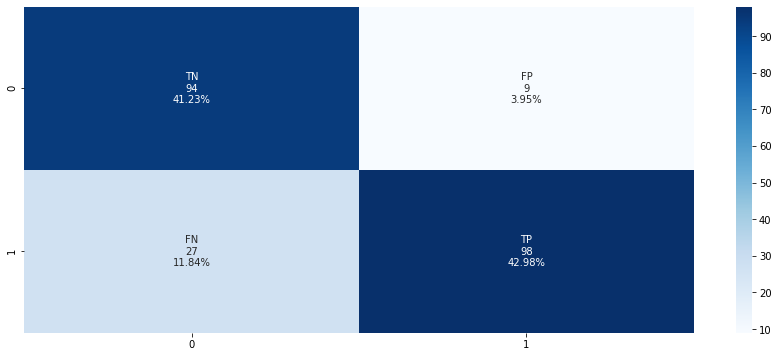

In [18]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

## Grid searching and making the model perform better
<p>Our model was pretty good! It was able to yield an accuracy score of almost 84%.</p>
<p>For the confusion matrix, the first element of the of the first row of the confusion matrix denotes the true negatives meaning the number of negative instances (denied applications) predicted by the model correctly. And the last element of the second row of the confusion matrix denotes the true positives meaning the number of positive instances (approved applications) predicted by the model correctly.</p>
<p>Let's see if we can do better. We can perform a <a href="https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/">grid search</a> of the model parameters to improve the model's ability to predict credit card approvals.</p>
<p><a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">scikit-learn's implementation of logistic regression</a> consists of different hyperparameters but we will grid search over the following two:</p>
<ul>
<li>tol</li>
<li>max_iter</li>
</ul>

In [19]:
# Define the grid of values for tol and max_iter
tol = [0.01, 0.001, 0.0001]
max_iter = [100, 150, 200]

# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_grid = dict(tol=tol, max_iter=max_iter)

## Finding the best performing model
<p>We have defined the grid of hyperparameter values and converted them into a single dictionary format which <code>GridSearchCV()</code> expects as one of its parameters. Now, we will begin the grid search to see which values perform best.</p>
<p>We will instantiate <code>GridSearchCV()</code> with our earlier <code>logreg</code> model with all the data we have. Instead of passing train and test sets separately, we will supply <code>X</code> (scaled version) and <code>y</code>. We will also instruct <code>GridSearchCV()</code> to perform a <a href="https://www.dataschool.io/machine-learning-with-scikit-learn/">cross-validation</a> of five folds.</p>
<p>We'll end the notebook by storing the best-achieved score and the respective best parameters.</p>
<p>While building this credit card predictor, we tackled some of the most widely-known preprocessing steps such as <strong>scaling</strong>, <strong>label encoding</strong>, and <strong>missing value imputation</strong>. We finished with some <strong>machine learning</strong> to predict if a person's application for a credit card would get approved or not given some information about that person.</p>

In [20]:
# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)

# Use scaler to rescale X and assign it to rescaledX
rescaledX = scaler.fit_transform(X)

# Fit data to grid_model
grid_model_result = grid_model.fit(rescaledX, y)

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print(f"Best: {best_score:f} using {best_params}")

Best: 0.850725 using {'max_iter': 100, 'tol': 0.01}
